In [1]:
!pip install split-folders

In [2]:
!pip install opencv--python

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
import tensorflow_hub as hub
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
!pip install -U tensorflow-addons

In [5]:
import tensorflow_addons as tfa

In [6]:
cd Desktop

C:\Users\abhin\Desktop


In [7]:
base_ds ='C:/Users/abhin/Desktop/Original Dataset'
base_ds = pathlib.Path(base_ds)

In [8]:
splitfolders.ratio(base_ds, output='imgs', seed=123, ratio=(.6,.2,.2), group_prefix=None)

Black_Measles= [fn for fn in os.listdir(f'{base_ds}/Black_Measles') if (fn.endswith('.JPG') or fn.endswith('.jpeg'))]
Black_rot= [fn for fn in os.listdir(f'{base_ds}/Black_rot') if (fn.endswith('.JPG')  or fn.endswith('.jpeg'))]
Leaf_blight= [fn for fn in os.listdir(f'{base_ds}/Leaf_blight') if (fn.endswith('.JPG')  or fn.endswith('.jpeg'))]


Leaf_blight= [fn for fn in os.listdir(f'{base_ds}/Leaf_blight') if (fn.endswith('.JPG')  or fn.endswith('.jpeg'))]
healthy= [fn for fn in os.listdir(f'{base_ds}/healthy') if (fn.endswith('.JPG')  or fn.endswith('.jpeg'))]
#Phoma= [fn for fn in os.listdir(f'{base_ds}/Phoma') if (fn.endswith('.jpg') or fn.endswith('.jpeg')
coffee= [Black_Measles,Black_rot,Leaf_blight,healthy]
coffee_classes = []
for i in os.listdir('imgs/train'):
    
    coffee_classes +=[i]
    coffee_classes.sort()

Copying files: 4062 files [00:52, 76.69 files/s] 


Total images: 4062
Total number of classes: 4
Total Black_Measles images: 1383
Total Black_rot images: 1180
Total Leaf_blight images: 1076
Total healthy images: 423


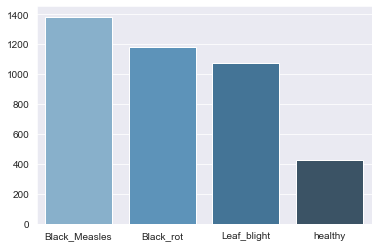

In [9]:
image_count1= len(list(base_ds.glob('*/*.JPG')))
image_count2 = len(list(base_ds.glob('*/*.jpeg')))
image_count=image_count1+image_count2
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(coffee_classes)}')
count = 0
coffee_count = []
for x in coffee_classes:
    
    print(f'Total {x} images: {len(coffee[count])}')
    coffee_count.append(len(coffee[count]))
    count+=1
sns.set_style('darkgrid')
sns.barplot(x=coffee_classes, y=coffee_count, palette="Blues_d")
plt.show()

Image dimensions: (256, 256, 3)


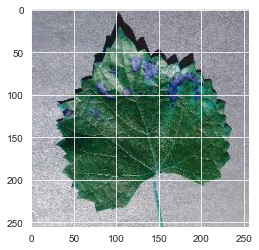

In [10]:
sample_img = cv2.imread('C:/Users/abhin/Desktop/Original Dataset/Black_Measles/image (10).JPG')
plt.imshow(sample_img)
print(f'Image dimensions: {sample_img.shape}')

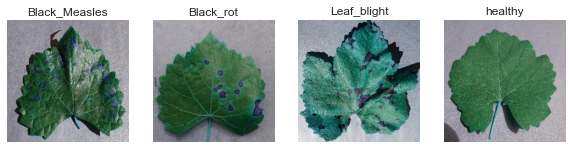

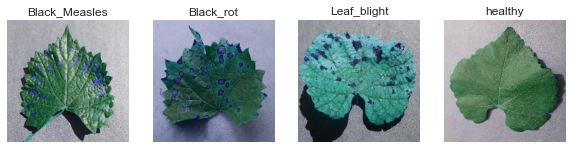

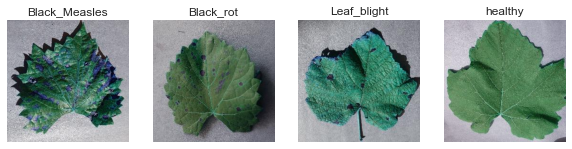

In [11]:
def load_random_img(dir, label):
    plt.figure(figsize=(10,10))
    i=0
    for label in coffee_classes:
        i+=1
        plt.subplot(1,4, i)
        file = random.choice(os.listdir(f'{dir}/{label}'))
        image_path = os.path.join(f'{dir}/{label}', file)
        img=cv2.imread(image_path)
        plt.title(label)
        plt.imshow(img)
        plt.grid(None)
        plt.axis('off')
for i in range(3):
       load_random_img(base_ds,coffee_classes)

In [12]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 100
image_size = 224 # We'll resize input images to this size
img_height, img_width = 512, 512
patch_size = 32 # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
 projection_dim * 2,
 projection_dim,
] # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024] # Size of the dense layers of the final classifier

In [13]:
train_datagen = ImageDataGenerator(
 rescale = 1./255.,
 rotation_range=30,
 zoom_range=0.15,
 width_shift_range=0.2,
 height_shift_range=0.2,
 shear_range=0.15,
 horizontal_flip=True,
 fill_mode="nearest",
 )
test_datagen = ImageDataGenerator(rescale = 1./255)
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_data = image_dataset_from_directory('imgs/train',
 label_mode = 'categorical',
 batch_size = batch_size,
 image_size = (image_size,image_size),
 shuffle = True,
 validation_split = 0.2,
 seed = 42,
 subset = 'training'
 )
test_data = image_dataset_from_directory('imgs/test',
 label_mode = 'categorical',
 batch_size = batch_size,
 image_size = (image_size,image_size),
 shuffle = False,
 )
valid_data = image_dataset_from_directory('imgs/val',
 label_mode = 'categorical',
 batch_size = batch_size,
 image_size = (image_size,image_size),
 shuffle = True,
 seed = 42,
 validation_split = 0.2,
 subset = 'validation'
 )



Found 2435 files belonging to 4 classes.
Using 1948 files for training.
Found 816 files belonging to 4 classes.
Found 811 files belonging to 4 classes.
Using 162 files for validation.


In [14]:
data_augmentation = keras.Sequential(
 [
 layers.Normalization(),
 layers.Resizing(image_size, image_size),
 layers.RandomFlip("horizontal"),
 layers.RandomRotation(factor=0.02),
 layers.RandomZoom(
 height_factor=0.2, width_factor=0.2
 ),
 ],
 name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
# data_augmentation.layers[0].adapt(train_data)
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [15]:
class Patches(layers.Layer):
    
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        super(Patches, self).__init__()
        self.patch_size = patch_size
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [16]:
import os

classes = os.listdir('C:/Users/abhin/Desktop/imgs/train')
train_length = len(os.listdir('C:/Users/abhin/Desktop/imgs/train/Black_Measles'))
train_length,classes

(829, ['Black_Measles', 'Black_rot', 'healthy', 'Leaf_blight'])

In [17]:
class_names = train_data.class_names
class_names

['Black_Measles', 'Black_rot', 'Leaf_blight', 'healthy']

In [18]:
train_dir = 'C:/Users/abhin/Desktop/imgs/train/'

Image size: 224 X 224
Patch size: 32 X 32
Patches per image: 49
Elements per patch: 3072


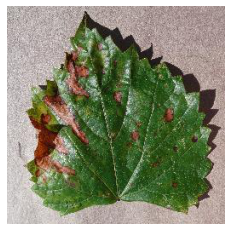

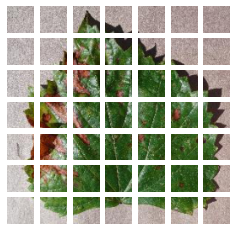

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(4, 4))
# random_class = random.choice(class_names)
target = train_dir + "Black_Measles"
random_num = random.choice(os.listdir(target))
image = mpimg.imread(train_dir + "Black_Measles" + "/" + random_num)
plt.imshow(image.astype("uint8"))
plt.axis("off")
resized_image = tf.image.resize(
 tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [20]:
class PatchEncoder(layers.Layer):
    
    def __init__(self, num_patches, projection_dim):
        
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
        input_dim=num_patches, output_dim=projection_dim
        )
    def call(self, patch):
        
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [21]:
def create_vit_classifier():
    
    inputs = layers.Input(shape=(image_size,image_size,3))
# Augment data.
    augmented = data_augmentation(inputs,training = True)
# Create patches.
    patches = Patches(patch_size)(augmented)
# Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
# Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        
# Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
# Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
         num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
# Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
# Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
# MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
# Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])
# Create a [batch_size, projection_dim] tensor.
        representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        representation = layers.Flatten()(representation)
        representation = layers.Dropout(0.5)(representation)
# Add MLP.
        features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
# Classify outputs.
        logits = layers.Dense(len(class_names))(features)
# Create the Keras model.
        model = keras.Model(inputs=inputs, outputs=logits)
        return model
    

In [22]:
import datetime

def create_tensorboard_callbacks(dir,model_number):
    log_dir = dir + model_number + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir = dir + model_number + datetime.datetime.now().strftime( )
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    return tensorboard_callback
                                                              

                                                              
feature_extractor_layer = hub.KerasLayer("https://tfhub.dev/sayakpaul/vit_r50_l32_fe/1",
                                 input_shape = (224,224,3),
                                 trainable = False,
                                 name = "Pre_trained")
model_1 = tf.keras.Sequential([
                              feature_extractor_layer,
                              layers.Dense(4,activation='softmax')
],name = "Model_1")
model_1.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Pre_trained (KerasLayer)    (None, 1024)              327969856 
                                                                 
 dense (Dense)               (None, 4)                 4100      
                                                                 
Total params: 327,973,956
Trainable params: 4,100
Non-trainable params: 327,969,856
_________________________________________________________________


In [23]:
model_1.compile(
 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
 optimizer = tfa.optimizers.AdamW(weight_decay = 0.0001,
                                  learning_rate = 0.001),
                                  metrics = ['accuracy'])
history_1 = model_1.fit(
 train_data ,
 epochs=5,
 validation_data = valid_data,
#  callbacks=[create_tensorboard_callbacks("Tesnorboard/","model_1/") ]
 )

Epoch 1/5


C:\Users\abhin\anaconda3\lib\site-packages\keras\backend.py:5534: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


31/31 [==============================] - 1113s 31s/step - loss: 0.9190 - accuracy: 0.7300 - val_loss: 0.1125 - val_accuracy: 0.9568
Epoch 2/5
31/31 [==============================] - 706s 23s/step - loss: 0.0847 - accuracy: 0.9682 - val_loss: 0.0494 - val_accuracy: 0.9815
Epoch 3/5
31/31 [==============================] - 690s 22s/step - loss: 0.0528 - accuracy: 0.9846 - val_loss: 0.0278 - val_accuracy: 0.9938
Epoch 4/5
31/31 [==============================] - 660s 21s/step - loss: 0.0403 - accuracy: 0.9887 - val_loss: 0.0348 - val_accuracy: 0.9877
Epoch 5/5
31/31 [==============================] - 3484s 115s/step - loss: 0.0361 - accuracy: 0.9897 - val_loss: 0.0177 - val_accuracy: 0.9938


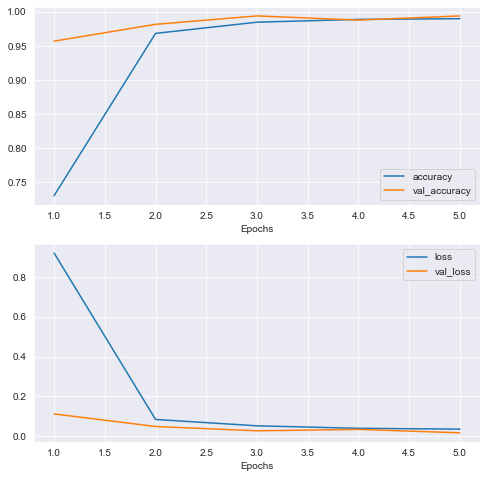

In [24]:
import matplotlib.pyplot as plt
def plot_graph(history):
    
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,2)
    epochs=range(1,len(history.history['loss'])+1)
    plt.plot(epochs,history.history['loss'],label='loss')
    plt.plot(epochs,history.history['val_loss'],label='val_loss')
    plt.xlabel('Epochs')
# plt.title('Training vs Validation loss')
    plt.legend()
    plt.subplot(2,1,1)
    plt.plot(epochs,history.history['accuracy'],label='accuracy')
    plt.plot(epochs,history.history['val_accuracy'],label='val_accuracy')
    plt.xlabel('Epochs')
# plt.title('Training vs Validation accuracy')
    plt.legend()
plot_graph(history_1)

In [25]:
import numpy as np
y_labels = []
for image,label in test_data.unbatch():
    
     y_labels.append(label.numpy().argmax())
pred_prob = model_1.predict(test_data)
preds = tf.argmax(pred_prob,axis = 1 )
print(y_labels[:10],preds[:10])

13/13 [==============================] - 591s 45s/step
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] tf.Tensor([0 0 0 0 0 0 0 0 0 0], shape=(10,), dtype=int64)


In [26]:
# vit_classifier.evaluate(test_data)
model_1.evaluate(test_data)

13/13 [==============================] - 880s 31s/step - loss: 0.0316 - accuracy: 0.9914


[0.0315781868994236, 0.9914215803146362]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels,preds))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       278
           1       1.00      0.97      0.99       236
           2       1.00      1.00      1.00       216
           3       1.00      1.00      1.00        86

    accuracy                           0.99       816
   macro avg       0.99      0.99      0.99       816
weighted avg       0.99      0.99      0.99       816



In [ ]:
def load_and_prep_image(filename,image_shape=224,scale=True):
    
    img = tf.io.read_file(filename)
    img = tf.io.decode_image(img,channels=3)
    img = tf.image.resize(img,size=[image_shape,image_shape])
    if scale:
        return img/255.
    else: 
        return img

In [ ]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_labels,preds)
c

array([[277,   1,   0,   0],
       [  6, 230,   0,   0],
       [  0,   0, 216,   0],
       [  0,   0,   0,  86]], dtype=int64)

1/1 [==============================] - 3s 3s/step


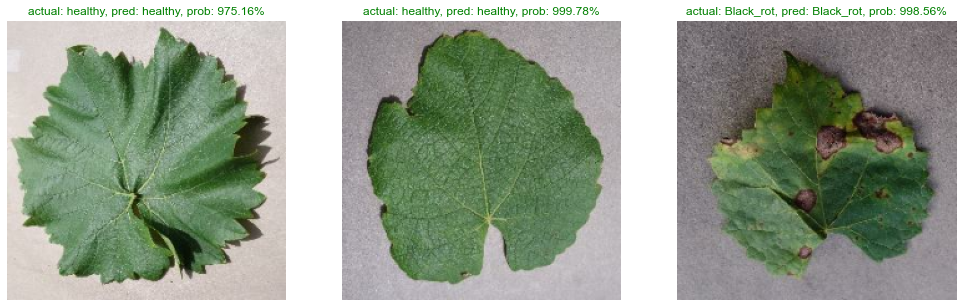

In [ ]:
import os
import random
plt.figure(figsize=(17,10))
for i in range(3):
    
    class_name=random.choice(test_data.class_names)
    filename=random.choice(os.listdir('imgs/test'+'/'+class_name))
    filepath='imgs/test'+"/"+class_name+'/'+filename
    img = load_and_prep_image(filepath,scale=True)
    pred_prob=model_1.predict(tf.expand_dims(img,axis=0))
    pred_class = test_data.class_names[pred_prob.argmax()]
    plt.subplot(1,3,i+1)
    plt.imshow(img)
    if class_name == pred_class:
        title_color='g'
    else:
        title_color='r'
    plt.title(f'actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max()*1000:.2f}%',c=title_color)
    plt.axis(False)

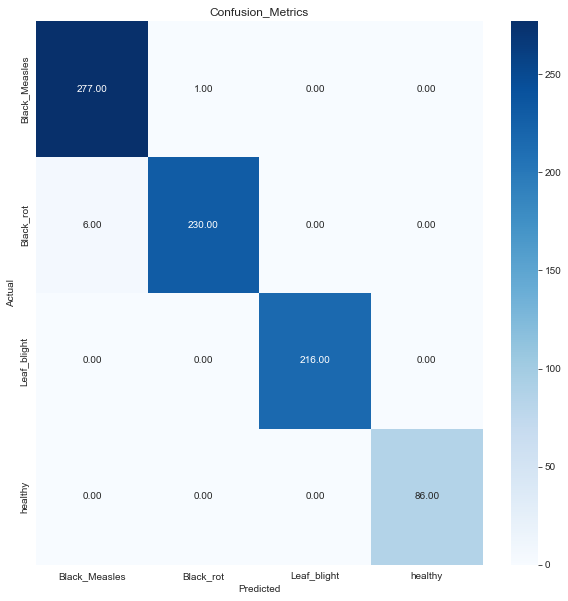

In [ ]:
import pandas as pd
d=pd.DataFrame.from_dict(history_1.history).to_csv('Adam_alpha_0.0001_batch_size_64_img=224.csv')

from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
def evaluation_function(y_preds,y_true):
    accuracy = accuracy_score(y_true,y_preds)*100
    precision = precision_score(y_true,y_preds,average = 'weighted')*100
    recall = recall_score(y_true,y_preds,average = 'weighted')*100
    f1 = f1_score(y_true,y_preds,average = 'weighted')*100
    confusion_metrics=confusion_matrix(y_true,y_preds)*100
    d={"Accuracy":accuracy,"Precision":precision,"Recall":recall,"F1-Score":f1}
    return d

evaluation_function(preds,y_labels)

{'Accuracy': 99.38725490196079,
     'Precision': 99.39091042767816,
     'Recall': 99.38725490196079,
     'F1-Score': 99.38693938045675}
    
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_labels,preds)
plt.figure(figsize = (10,10))
ax = sns.heatmap(cm,fmt='.2f', annot=True, cmap='Blues')
ax.set_title("Confusion_Metrics")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.xaxis.set_ticklabels(test_data.class_names)
ax.yaxis.set_ticklabels(test_data.class_names)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
my_index = ['Accuracy']
my_columns = ['AlexNet','MobileNet','VGG16','Deep CNN','Proposed ViT']
my_data = [95.7,98.1,96.6,98.4,99.14]
df=pd.DataFrame(data= my_data,columns = ['Test Accuracy'], index=my_columns)

In [ ]:
df

,Test Accuracy
AlexNet,95.70
MobileNet,98.10
VGG16,96.60
Deep CNN,98.40
Proposed ViT,99.14


Text(0.5, 1.0, 'Comparison Chart')

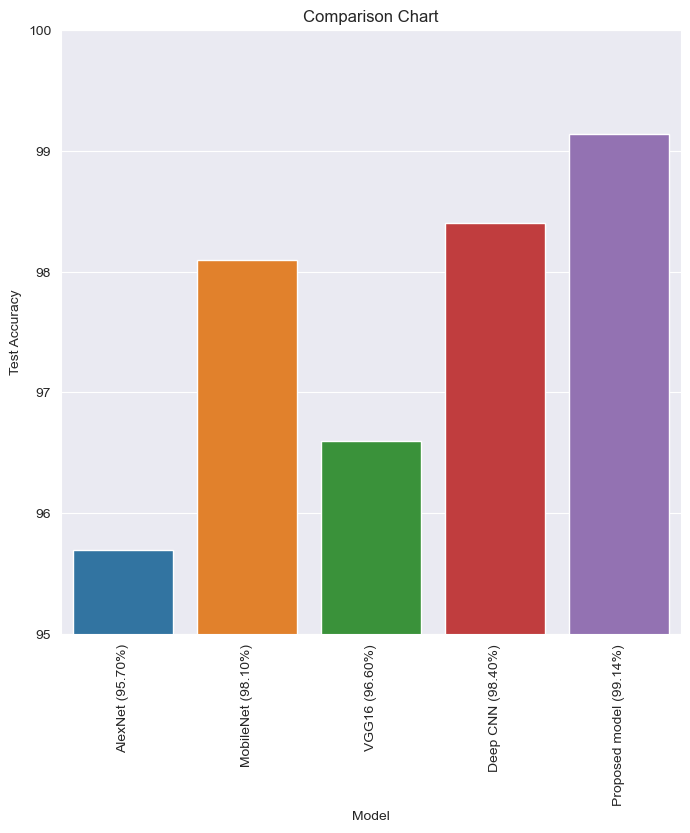

In [ ]:
plt.figure(figsize=(8,8),dpi=100)

ax = sns.barplot(x=['AlexNet (95.70%)','MobileNet (98.10%)','VGG16 (96.60%)','Deep CNN (98.40%)','Proposed model (99.14%)'],y='Test Accuracy',data=df)
ax.set(ylim=(95, 100))
plt.xticks(rotation=90);
ax.set_xlabel('Model')
ax.set_title('Comparison Chart')